In [1]:
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx
import lightgbm as lgb
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
from sklearn.cluster import KMeans

In [2]:
train = pd.read_csv('FIR_Details_Data.csv')

In [3]:
train.dtypes

District_Name           object
Year                     int64
Month                    int64
FIR Type                object
CrimeGroup_Name         object
CrimeHead_Name          object
Distance from PS        object
Male                     int64
Female                   int64
Boy                      int64
Girl                     int64
Age 0                    int64
VICTIM COUNT             int64
Accused Count            int64
Arrested Male            int64
Arrested Female          int64
Arrested Count\tNo.      int64
Latitude               float64
Longitude              float64
dtype: object

In [4]:
train.duplicated().sum()

7049

C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\2613545302.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


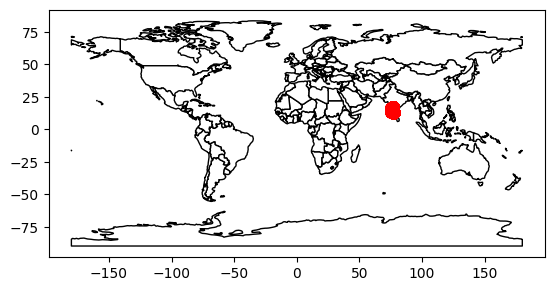

In [5]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.Longitude, gdf.Latitude))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [6]:
print(train_gdf.loc[train_gdf.Longitude > 50].count()[0])
train_gdf.loc[train_gdf.Longitude > 50].sample(5)

120954


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\268961221.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(train_gdf.loc[train_gdf.Longitude > 50].count()[0])


,District_Name,Year,Month,FIR Type,CrimeGroup_Name,CrimeHead_Name,Distance from PS,Male,Female,Boy,Girl,Age 0,VICTIM COUNT,Accused Count,Arrested Male,Arrested Female,Arrested Count\tNo.,Latitude,Longitude,Coordinates
26238,Belagavi Dist,2022,9,Non Heinous,BURGLARY - DAY,At Residential Premises,Toards east 03 km from ps,0,1,0,0,0,0,0,0,0,0,15.639786,74.530845,POINT (74.53084 15.63979)
40290,Bengaluru City,2021,11,Non Heinous,MOTOR VEHICLE ACCIDENTS NON-FATAL,Other Roads,To words south by 2km,1,0,0,0,0,0,1,1,0,1,12.936833,77.531738,POINT (77.53174 12.93683)
85081,Bengaluru City,2017,3,Non Heinous,PUBLIC SAFETY,Public Safety,0.5 KM TOWARDS NORTH,0,0,0,0,0,0,1,1,0,1,13.039282,77.589462,POINT (77.58946 13.03928)
58591,Bengaluru City,2018,1,Non Heinous,CHEATING,CHEATING,800 mtrs towards station,1,0,0,0,0,0,6,0,0,0,13.011954,77.595540,POINT (77.59554 13.01195)
3596,Bagalkot,2022,5,Non Heinous,MISSING PERSON,Man,East Side 9 KM From Ps,1,0,0,0,0,0,0,0,0,0,16.301672,75.661782,POINT (75.66178 16.30167)


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\1943895520.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


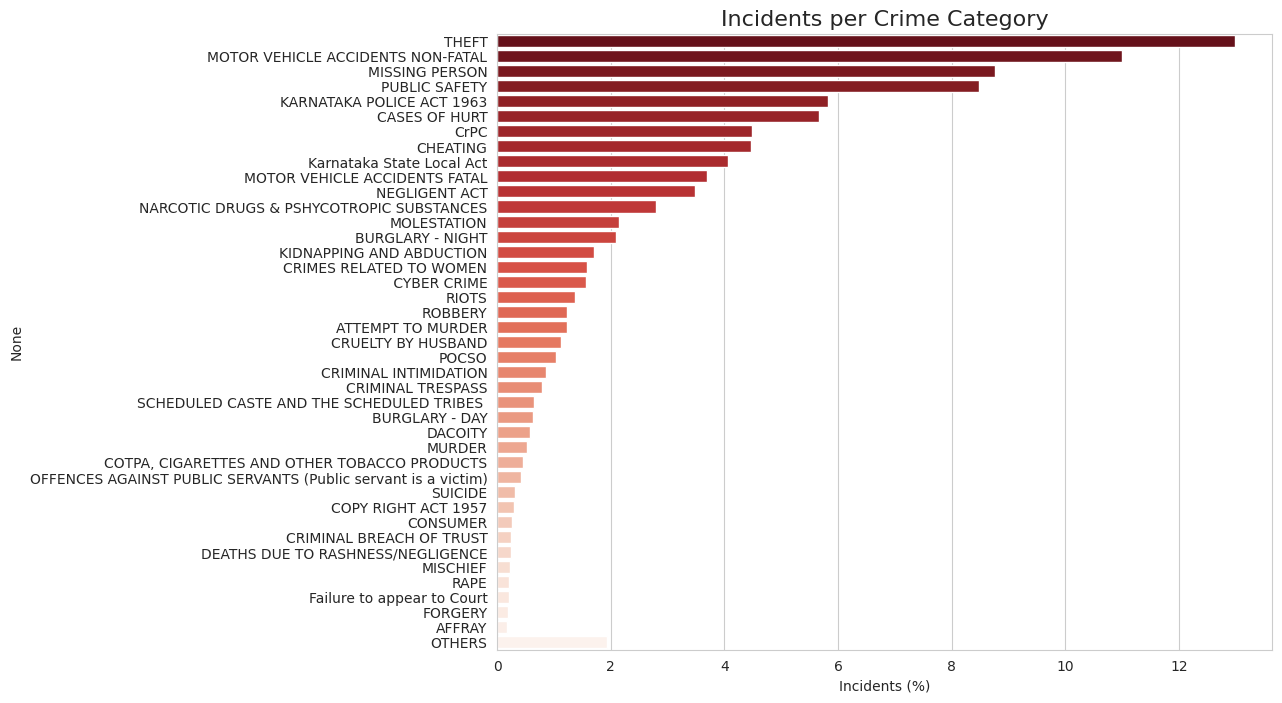

In [7]:
# Group by category and count incidents
data = train.groupby('CrimeGroup_Name').count().iloc[:, 0].sort_values(ascending=False)

# Keep top N categories and group the rest into "OTHERS"
top_n = 40  # Specify the number of top categories to keep
top_categories = data[:top_n]
other_count = data[top_n:].sum()
data = pd.concat([top_categories, pd.Series({'OTHERS': other_count})])

# Plotting
plt.figure(figsize=(10, 8))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x=(data.values / data.values.sum()) * 100,
        y=data.index,
        palette="Reds_r"
    )

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

In [8]:
n_rows = train.shape[0]

naive_vals = train.groupby('CrimeGroup_Name').count().iloc[:,0]/train.shape[0]
n_groups = len(naive_vals)

# Repeat the array of naive_vals to match the number of rows
repeated_vals = np.repeat(np.array(naive_vals), n_rows)

# Reshape the repeated values into a shape where each row represents a crime group
# and each column represents a row in the original DataFrame
reshaped_vals = repeated_vals.reshape(n_groups, n_rows).transpose()

# Create a DataFrame from the reshaped values with columns as the crime group names
submission = pd.DataFrame(reshaped_vals, columns=naive_vals.index)

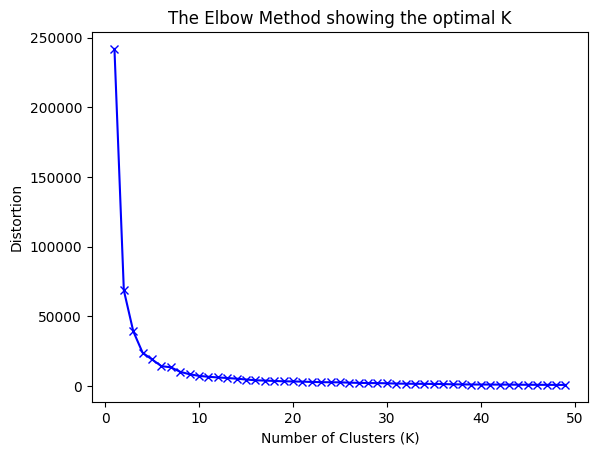

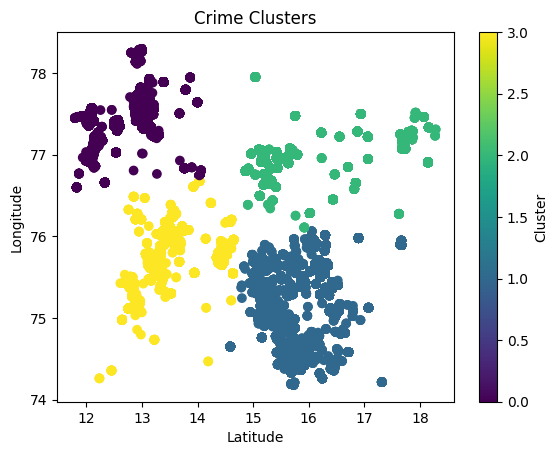

Cluster Centers:
[[12.9270198  77.50799054]
 [15.95364318 75.19260958]
 [15.835278   76.9363887 ]
 [13.51833976 75.67411135]]


In [9]:
# Load the data
data = pd.read_csv("FIR_Details_Data.csv")

# Select relevant features for clustering
X = data[['Latitude', 'Longitude']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choosing K using the Elbow method
distortions = []
K = range(1, 50)
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(X_scaled)
    distortions.append(kmeans_model.inertia_)

# Plotting the Elbow method to visualize the optimal K
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K')
plt.show()

# Based on the plot, choose an optimal K and run KMeans
optimal_k = 4  # Change this based on the Elbow Method plot
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_model.fit(X_scaled)

# Adding cluster labels to the original dataset
data['Cluster'] = kmeans_model.labels_

# Visualizing the clusters
plt.scatter(data['Latitude'], data['Longitude'], c=data['Cluster'], cmap='viridis')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Crime Clusters')
plt.colorbar(label='Cluster')
plt.show()

# Optional: Print cluster centers
print("Cluster Centers:")
print(scaler.inverse_transform(kmeans_model.cluster_centers_))


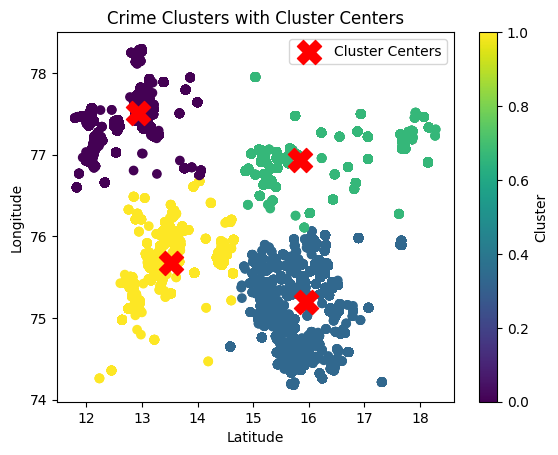

Cluster Distribution:
Cluster
0    83787
1    17211
2    13665
3     6291
Name: count, dtype: int64
Silhouette Score: 0.7688567355775385


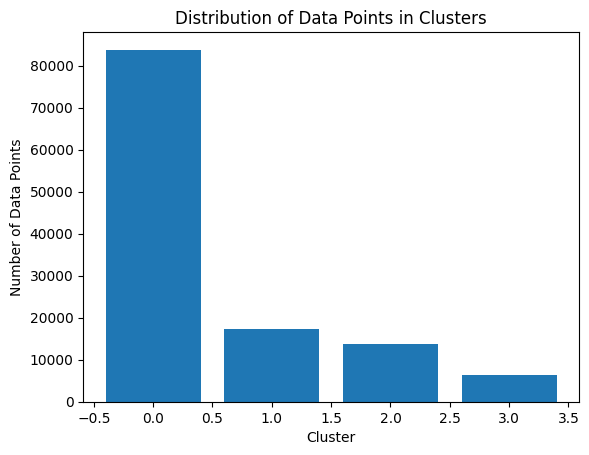

In [10]:
# Visualizing the clusters with cluster centers
plt.scatter(data['Latitude'], data['Longitude'], c=data['Cluster'], cmap='viridis')
plt.scatter(scaler.inverse_transform(kmeans_model.cluster_centers_)[:, 0], 
            scaler.inverse_transform(kmeans_model.cluster_centers_)[:, 1], 
            s=300, c='red', marker='X', label='Cluster Centers')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Crime Clusters with Cluster Centers')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

# Analysis and Accuracy
# Assessing the distribution of data points in each cluster
cluster_counts = data['Cluster'].value_counts()
print("Cluster Distribution:")
print(cluster_counts)

# Calculating the silhouette score for the clustering
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_scaled, kmeans_model.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Visualizing cluster distribution
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points in Clusters')
plt.show()

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load your data
data = pd.read_csv("FIR_Details_Data.csv")  # Replace "your_data.csv" with the path to your CSV file containing the data

# Select relevant features for clustering
X = data[['Latitude', 'Longitude']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform KMeans clustering
k = 4  # You can choose the number of clusters based on your analysis
kmeans_model = KMeans(n_clusters=k, random_state=42)
kmeans_model.fit(X_scaled)

# Add cluster labels to the DataFrame
data['Cluster'] = kmeans_model.labels_

# Now, we can proceed to identify high crime areas
# Count the number of incidents in each cluster
cluster_counts = data['Cluster'].value_counts()

# Find the cluster(s) with the highest number of incidents
high_crime_clusters = cluster_counts[cluster_counts == cluster_counts.max()].index.tolist()

# Filter the data for high crime clusters
high_crime_data = data[data['Cluster'].isin(high_crime_clusters)]

# Import necessary libraries
import folium
import random

# Create a map centered on average latitude and longitude of high crime areas
map_center = (high_crime_data['Latitude'].mean(), high_crime_data['Longitude'].mean())
mymap = folium.Map(location=map_center, zoom_start=10)

# Set maximum number of markers per cluster
max_markers_per_cluster = 1000

# Add markers for a sample of incidents from each high crime area
for cluster_id in high_crime_clusters:
    cluster_data = high_crime_data[high_crime_data['Cluster'] == cluster_id]
    sample_data = cluster_data.sample(min(len(cluster_data), max_markers_per_cluster), random_state=42)
    for index, row in sample_data.iterrows():
        folium.Marker(location=[row['Latitude'], row['Longitude']],
                      popup=f"Cluster: {row['Cluster']}, Crime Group: {row['CrimeGroup_Name']}",
                      icon=folium.Icon(color='red')).add_to(mymap)

# Display the map
mymap.save("high_crime_areas_map.html")  # Save the map as an HTML file
mymap


Budget Allocation for Each Cluster:
Cluster
0    692717.89
1    142293.76
2    112976.83
3     52011.51
Name: count, dtype: float64


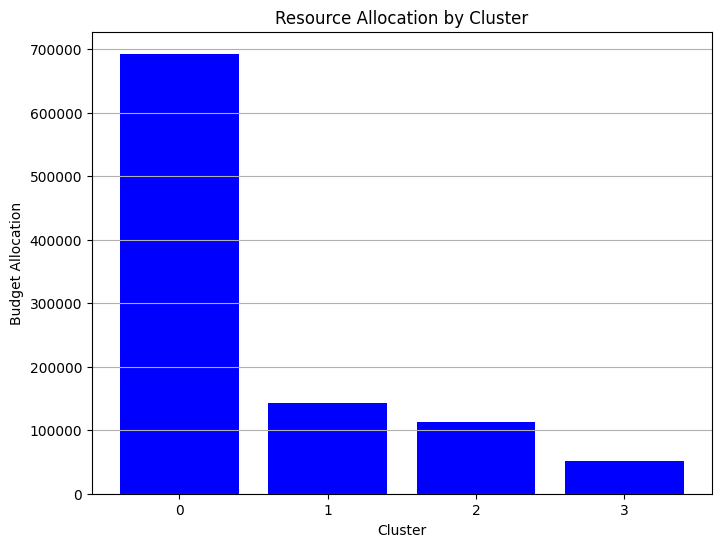

In [12]:
# Assuming you have already performed clustering and have a DataFrame named 'data' containing the cluster labels

# Count the number of incidents in each cluster
cluster_counts = data['Cluster'].value_counts()

# Calculate the proportion of incidents in each cluster
cluster_proportions = cluster_counts / cluster_counts.sum()

# Assuming you have a total budget for resource allocation
total_budget = 1000000  # Example budget of 1,000,000 units

# Calculate the budget allocation for each cluster based on the proportion of incidents
cluster_budgets = (cluster_proportions * total_budget).round(2)

# Print the budget allocation for each cluster
print("Budget Allocation for Each Cluster:")
print(cluster_budgets)

# Visualize the budget allocation
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(cluster_budgets.index, cluster_budgets.values, color='blue')
plt.xlabel('Cluster')
plt.ylabel('Budget Allocation')
plt.title('Resource Allocation by Cluster')
plt.xticks(cluster_budgets.index)
plt.grid(axis='y')
plt.show()


In [13]:
import pandas as pd
from sklearn.cluster import KMeans

# Load your dataset
data = pd.read_csv("FIR_Details_Data.csv")  # Replace "your_data.csv" with the path to your dataset

# Assuming you have already performed clustering and have a DataFrame named 'data' containing the cluster labels
# Cluster the data
num_clusters = 4  # You can choose the number of clusters based on your analysis
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans_model.fit_predict(data[['Latitude', 'Longitude']])

# Analyze the types of crimes occurring in each cluster
cluster_crime_types = data.groupby('Cluster')['CrimeGroup_Name'].value_counts()

# Devising targeted crime prevention strategies based on predominant crime types in each cluster
for cluster_id in range(num_clusters):
    cluster_data = cluster_crime_types[cluster_id]
    predominant_crime_type = cluster_data.idxmax()  # Most common crime type in the cluster
    print(f"Cluster {cluster_id + 1}: Predominant Crime Type - {predominant_crime_type}")
    
    # Based on the predominant crime type, devise targeted crime prevention strategies
    if predominant_crime_type == 'Motor Vehicle Accidents':
        print("Strategy: Improve road infrastructure and implement traffic regulations.")
    elif predominant_crime_type == 'Burglary':
        print("Strategy: Enhance neighborhood watch programs and increase police patrols in residential areas.")
    # Add more conditions for other predominant crime types as needed
    else:
        print("Strategy: Implement measures tailored to address the specific crime challenges in this cluster.")


Cluster 1: Predominant Crime Type - THEFT
Strategy: Implement measures tailored to address the specific crime challenges in this cluster.
Cluster 2: Predominant Crime Type - KARNATAKA POLICE ACT 1963
Strategy: Implement measures tailored to address the specific crime challenges in this cluster.
Cluster 3: Predominant Crime Type - MOTOR VEHICLE ACCIDENTS NON-FATAL
Strategy: Implement measures tailored to address the specific crime challenges in this cluster.
Cluster 4: Predominant Crime Type - MOTOR VEHICLE ACCIDENTS NON-FATAL
Strategy: Implement measures tailored to address the specific crime challenges in this cluster.


Silhouette Scores:
Year 2016: 0.6670062679288945
Year 2017: 0.79143619261133
Year 2018: 0.7709348132786741
Year 2019: 0.7384365562046586
Year 2020: 0.7113989345389732
Year 2021: 0.6976900561364455
Year 2022: 0.7032301011277036
Year 2023: 0.7366601914357253
Year 2024: 0.7389562017386041


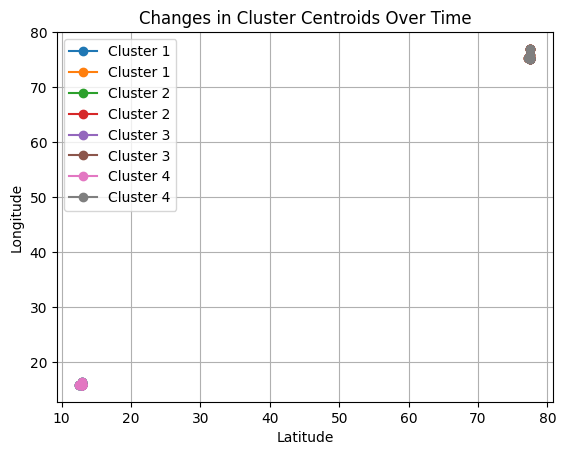

In [15]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Get unique time periods from the 'Year' column
time_periods = np.sort(data['Year'].unique())

# Dictionary to store silhouette scores for each time period
silhouette_scores_by_time = {}
cluster_labels_by_time = {}

# Iterate over each time period
for time_period in time_periods:
    # Filter the data for the current time period
    time_period_data = data[data['Year'] == time_period]
    
    # Perform clustering on the filtered data
    kmeans_model = KMeans(n_clusters=4, random_state=42)  # You can adjust the number of clusters
    cluster_labels = kmeans_model.fit_predict(time_period_data[['Latitude', 'Longitude']])
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(time_period_data[['Latitude', 'Longitude']], cluster_labels)
    silhouette_scores_by_time[time_period] = silhouette_avg

    # Store the cluster labels for the current time period
    cluster_labels_by_time[time_period] = cluster_labels

# Print silhouette scores for each time period
print("Silhouette Scores:")
for time_period, score in silhouette_scores_by_time.items():
    print(f"Year {time_period}: {score}")

# Analyze clustering patterns over time to identify trends
# For example, you can visualize the changes in cluster centroids or silhouette scores over time
# You can also compare cluster sizes or examine shifts in predominant crime types within clusters
# These analyses can help identify emerging trends or shifts in crime patterns

# Example: Visualizing changes in cluster centroids over time
import matplotlib.pyplot as plt

# Extract cluster centroids for each time period
cluster_centroids_by_time = {}
for time_period, cluster_labels in cluster_labels_by_time.items():
    cluster_centers = []
    for cluster_id in range(4):  # Assuming 3 clusters
        cluster_data = data.loc[data['Year'] == time_period]
        cluster_center = cluster_data.loc[cluster_labels == cluster_id, ['Latitude', 'Longitude']].mean()
        cluster_centers.append(cluster_center)
    cluster_centroids_by_time[time_period] = cluster_centers

# Plot changes in cluster centroids over time
for cluster_id in range(4):  # Assuming 3 clusters
    centroid_latitudes = [centroid[0] for centroid in cluster_centroids_by_time.values()]
    centroid_longitudes = [centroid[1] for centroid in cluster_centroids_by_time.values()]
    plt.plot(centroid_latitudes, centroid_longitudes, marker='o', label=f'Cluster {cluster_id + 1}')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Changes in Cluster Centroids Over Time')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


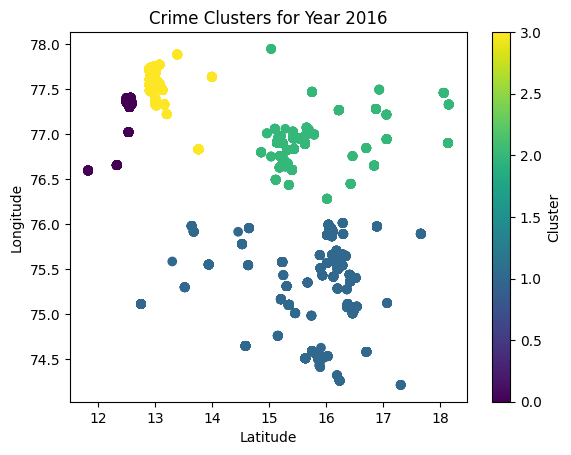

Cluster Centers for Year 2016:
[[12.53166111 77.32283898]
 [15.65488734 75.23611248]
 [15.76072967 76.93518135]
 [13.01082572 77.54439541]]


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


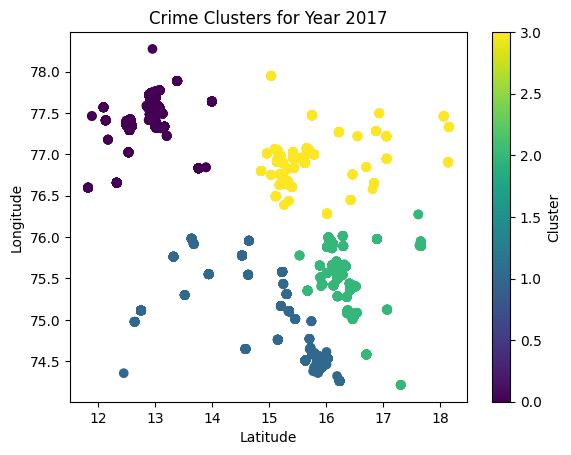

Cluster Centers for Year 2017:
[[12.93811572 77.51280921]
 [14.90690596 75.00294359]
 [16.33301037 75.57170157]
 [15.69073426 76.91168676]]


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


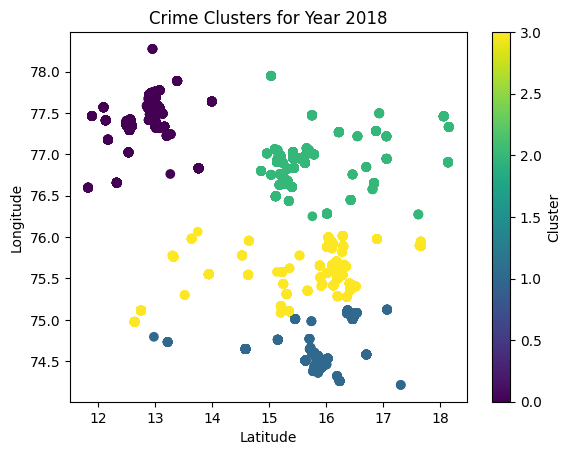

Cluster Centers for Year 2018:
[[12.92524716 77.51556864]
 [15.83637932 74.65506863]
 [15.7655513  76.90525648]
 [15.62572434 75.58599285]]


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


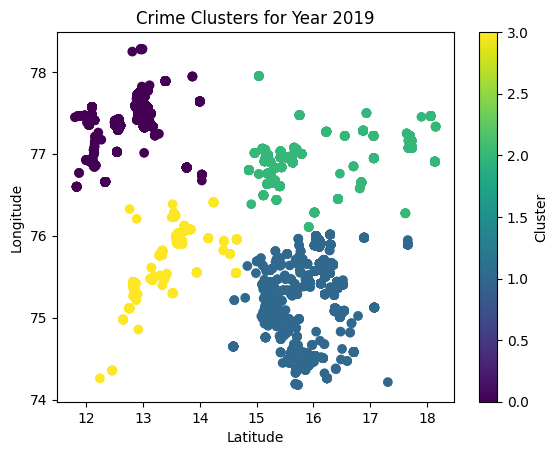

Cluster Centers for Year 2019:
[[12.91752452 77.51099214]
 [15.96792389 75.20666494]
 [15.84000939 76.93590369]
 [13.37238634 75.63368342]]


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


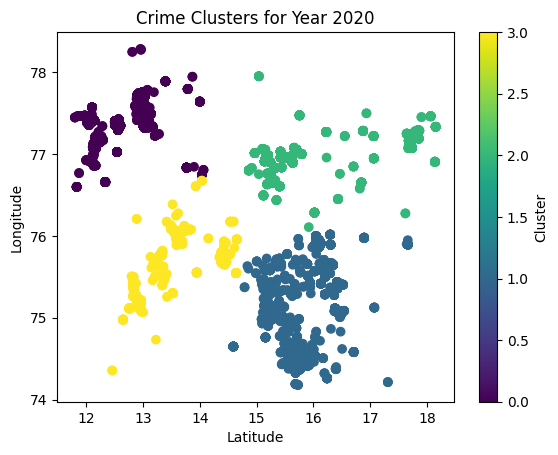

Cluster Centers for Year 2020:
[[12.893649   77.49586967]
 [15.912536   75.1586549 ]
 [15.91122044 76.93948673]
 [13.46202697 75.64141755]]


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


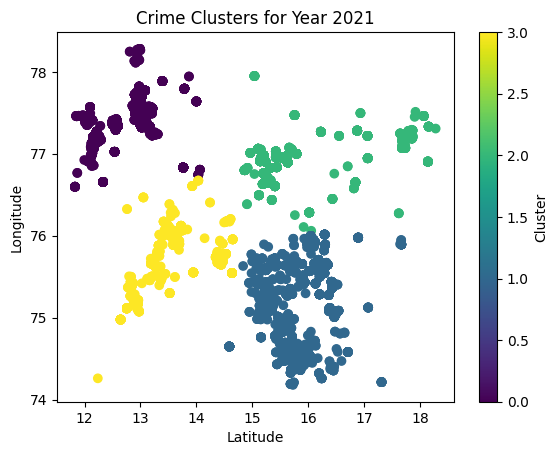

Cluster Centers for Year 2021:
[[12.91909753 77.4926826 ]
 [15.87972859 75.16349825]
 [15.90369313 76.94657996]
 [13.52672389 75.68403079]]


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


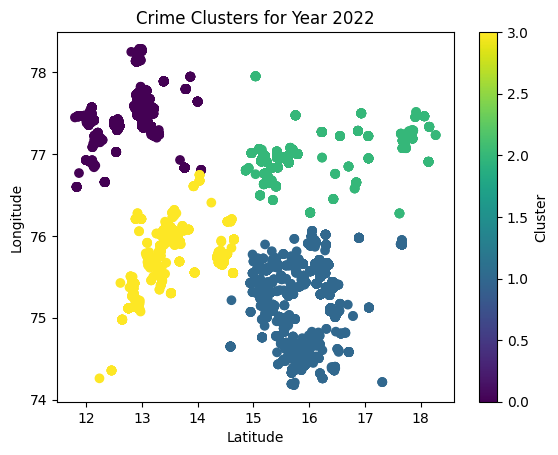

Cluster Centers for Year 2022:
[[12.94269643 77.49982395]
 [15.89908506 75.17590197]
 [15.89186189 76.95649986]
 [13.55434798 75.7549794 ]]


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


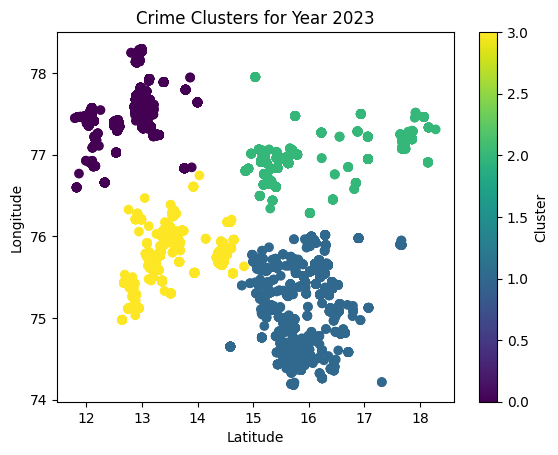

Cluster Centers for Year 2023:
[[12.93286729 77.51597019]
 [15.91119272 75.16630249]
 [15.92643996 76.95525867]
 [13.57474995 75.76663763]]


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\3092490788.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['Cluster'] = kmeans_model.labels_


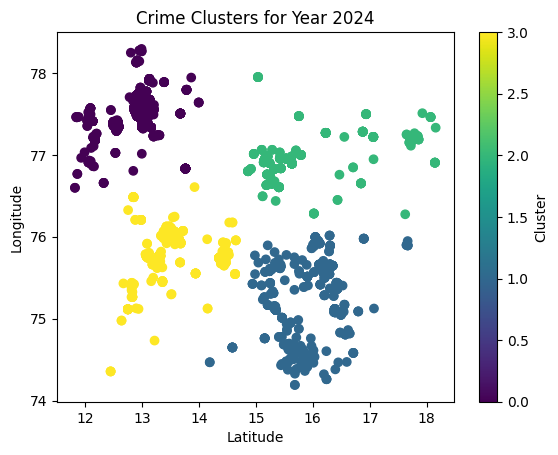

Cluster Centers for Year 2024:
[[12.92695503 77.52713643]
 [15.91634813 75.21687316]
 [15.85706968 76.97923053]
 [13.58475374 75.78151762]]


In [16]:
# Load the data
data = pd.read_csv("FIR_Details_Data.csv")  # Replace "your_data.csv" with the path to your CSV file

# Assuming you have 'Year' column in your dataset
# Select relevant features for clustering
features = ['Latitude', 'Longitude']
X = data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the range of years in the dataset
years = data['Year'].unique()

# Dictionary to store cluster labels for each year
cluster_labels_by_year = {}

# Iterate over each year
for year in years:
    # Filter the data for the current year
    year_data = data[data['Year'] == year]
    X_year = year_data[features]
    
    # Standardize features for the current year
    X_year_scaled = scaler.transform(X_year)
    
    # Based on the plot, choose an optimal K and run KMeans
    optimal_k = 4  # Change this based on the Elbow Method plot
    kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans_model.fit(X_year_scaled)

    # Adding cluster labels to the original dataset for the current year
    year_data['Cluster'] = kmeans_model.labels_
    cluster_labels_by_year[year] = kmeans_model.labels_

    # Visualizing the clusters for the current year
    plt.scatter(year_data['Latitude'], year_data['Longitude'], c=year_data['Cluster'], cmap='viridis')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title(f'Crime Clusters for Year {year}')
    plt.colorbar(label='Cluster')
    plt.show()

    # Optional: Print cluster centers for the current year
    print(f"Cluster Centers for Year {year}:")
    print(scaler.inverse_transform(kmeans_model.cluster_centers_))


In [17]:
import geopandas as gpd

# Load the shapefile for the districts
district_shapes = gpd.read_file('District/District.shp')

# Display the attribute table
print(district_shapes.head())

# Optionally, you can list all the column names to find the one that uniquely identifies each district
print(district_shapes.columns)


  KGISDistri  LGD_Distri  KGISDist_1 BhuCodeDis created_us created_da  \
0         01         527    Belagavi         01       None       None   
1         02         524    Bagalkot         02       None       None   
2         03         530  Vijayapura         03       None       None   
3         04         538    Kalburgi         04       None       None   
4         05         529       Bidar         05       None       None   

  last_edite  last_edi_1    SHAPE_STAr    SHAPE_STLe  \
0  SURESHBV1  2022-11-24  1.339772e+10  1.141488e+06   
1  SURESHBV1  2022-09-08  6.561826e+09  6.682456e+05   
2  SURESHBV1  2022-11-24  1.050271e+10  7.032618e+05   
3  SURESHBV1  2022-11-09  1.097395e+10  9.181459e+05   
4  SURESHBV1  2022-11-16  5.454415e+09  5.733925e+05   

                                            geometry  
0  MULTIPOLYGON (((537523.310 1865366.861, 537555...  
1  POLYGON ((581917.898 1811433.959, 581946.875 1...  
2  POLYGON ((537523.310 1865366.861, 537516.168 1...  
3  M

Enter the district name:  Bagalkot


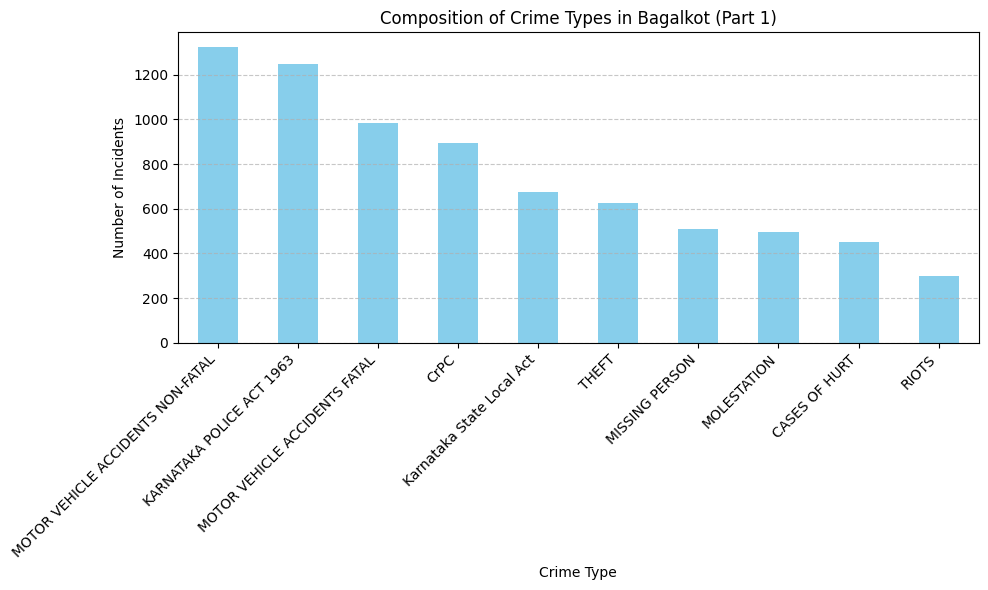

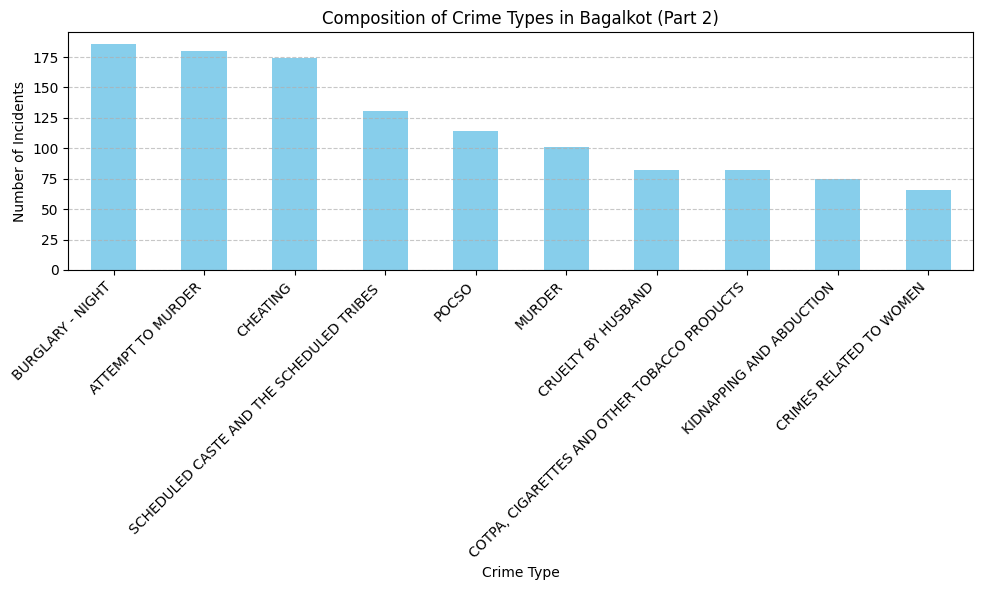

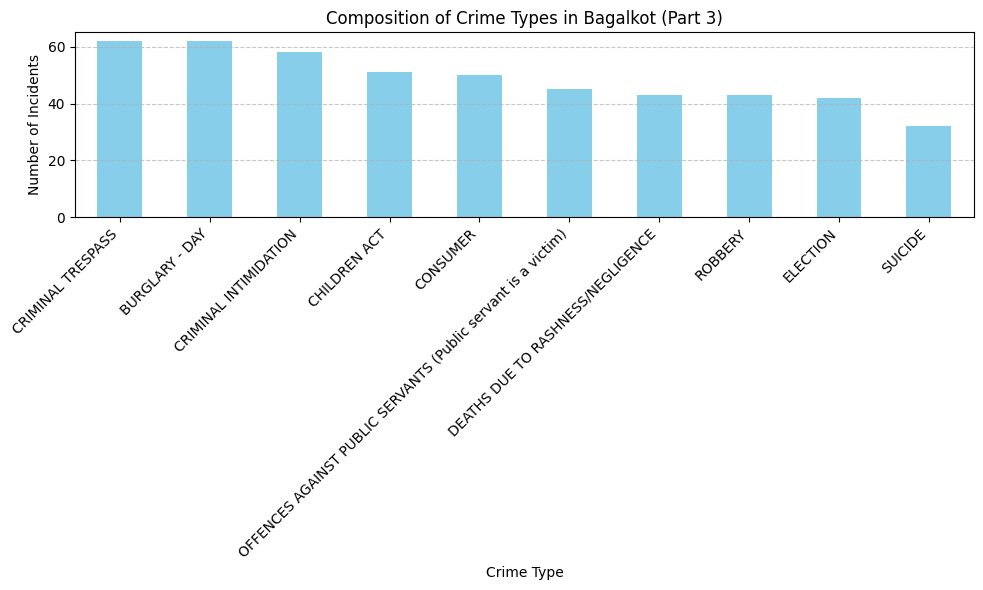

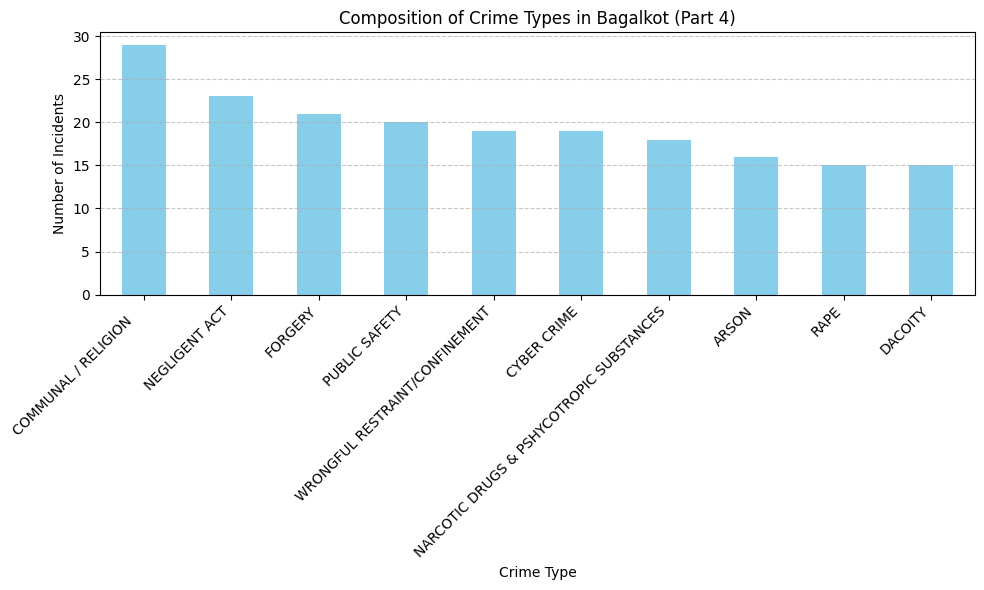

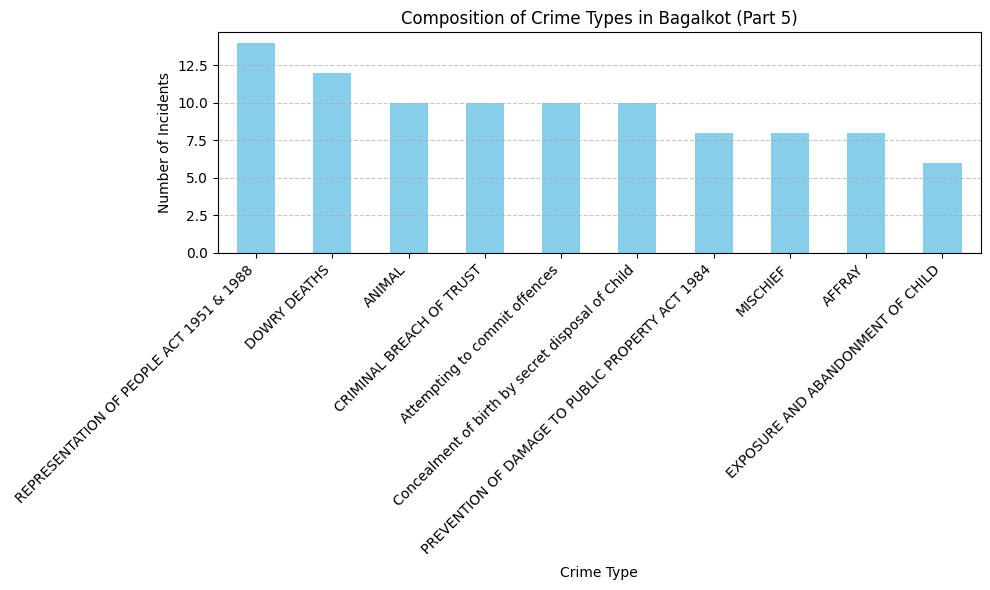

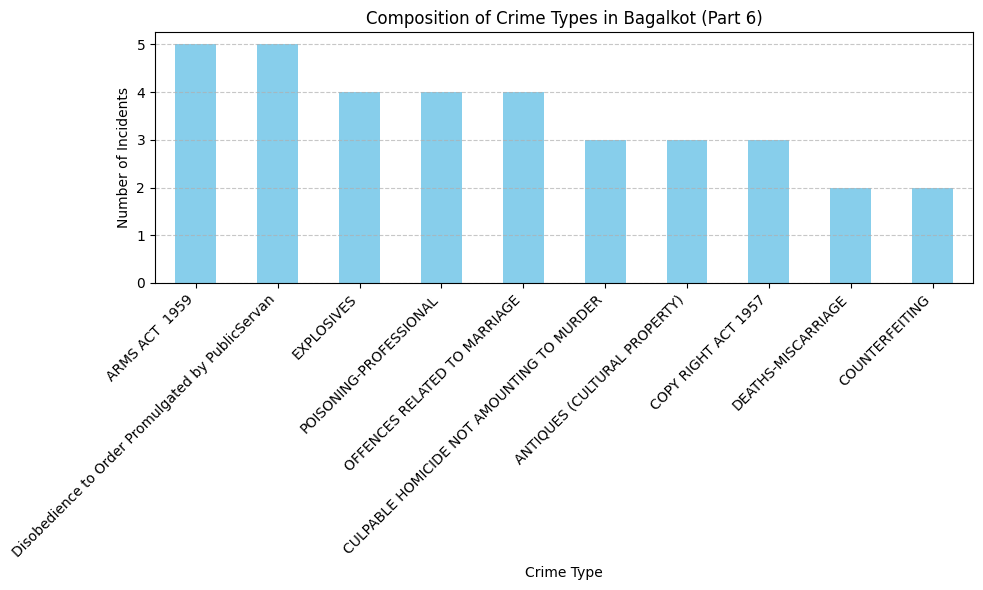

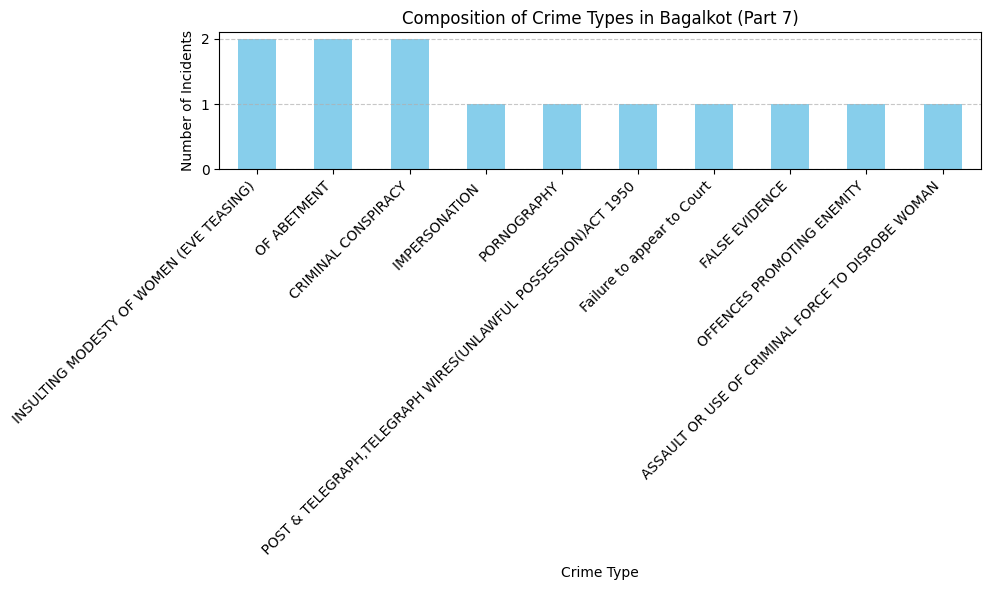

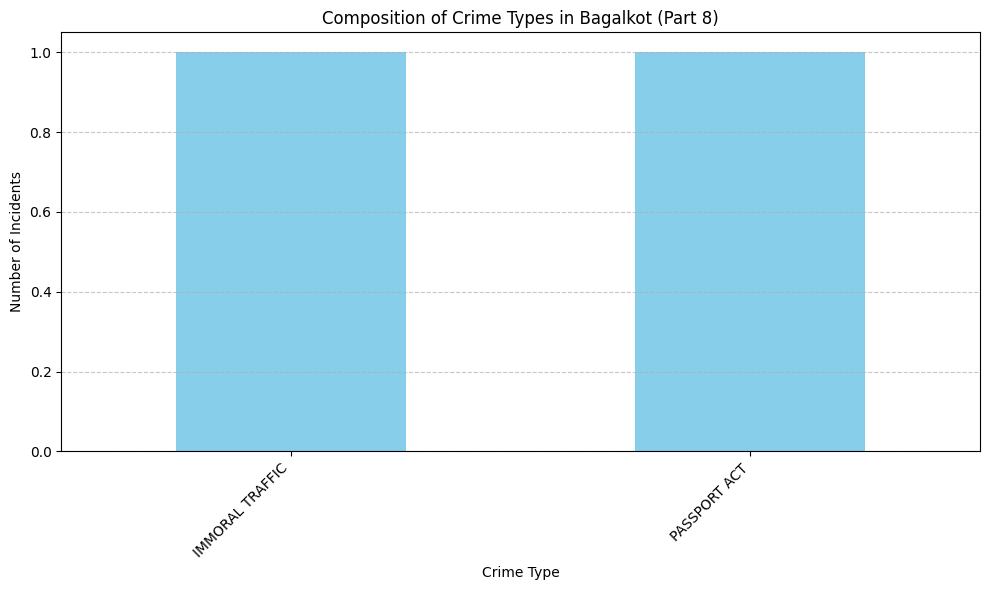

C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\2017729727.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Date'] = pd.to_datetime(district_data[['Year', 'Month']].assign(day=1))  # Combine year and month into a single datetime column


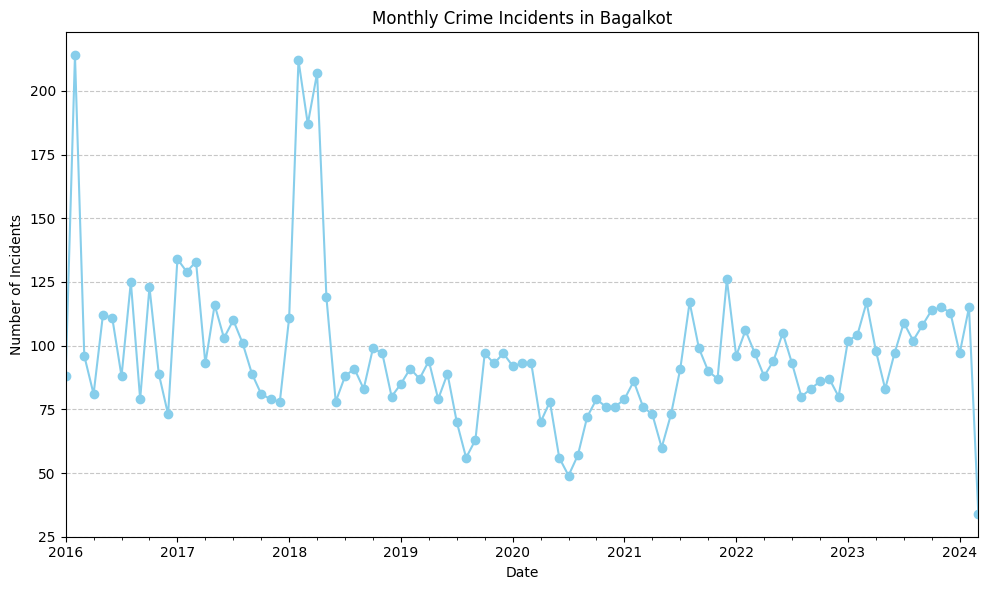

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('FIR_Details_Data.csv')

# Ask user to input district name
district_name = input("Enter the district name: ")

# Filter data for the selected district
district_data = data[data['District_Name'] == district_name]

if district_data.empty:
    print("District not found.")
else:
    # Aggregate data by crime group name
    crime_group_counts = district_data['CrimeGroup_Name'].value_counts()

    # Remove categories with zero incidents
    crime_group_counts = crime_group_counts[crime_group_counts > 0]

    if not crime_group_counts.empty:
        # Divide crime types into groups
        groups = [crime_group_counts[i:i+10] for i in range(0, len(crime_group_counts), 10)]

        # Plotting each group separately
        for i, group in enumerate(groups, start=1):
            plt.figure(figsize=(10, 6))
            group.plot(kind='bar', color='skyblue')
            plt.title('Composition of Crime Types in {} (Part {})'.format(district_name, i))
            plt.xlabel('Crime Type')
            plt.ylabel('Number of Incidents')
            plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust font size
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
    else:
        print("No crime incidents reported in the selected district.")


# Trend Analysis: Monthly Crime Incidents
# Assuming you have 'Year' and 'Month' columns in your dataset
district_data['Date'] = pd.to_datetime(district_data[['Year', 'Month']].assign(day=1))  # Combine year and month into a single datetime column

# Aggregate data by month
monthly_crime_counts = district_data.groupby('Date').size()

# Plotting
plt.figure(figsize=(10, 6))
monthly_crime_counts.plot(marker='o', color='skyblue')
plt.title('Monthly Crime Incidents in {}'.format(district_name))
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




Enter the district name:  Bagalkot



Types of Crimes in Bagalkot
CrimeGroup_Name
MOTOR VEHICLE ACCIDENTS NON-FATAL                    1323
KARNATAKA POLICE ACT 1963                            1247
MOTOR VEHICLE ACCIDENTS FATAL                         984
CrPC                                                  896
Karnataka State Local Act                             674
                                                     ... 
FALSE EVIDENCE                                          1
OFFENCES PROMOTING ENEMITY                              1
ASSAULT OR USE OF CRIMINAL FORCE TO DISROBE WOMAN       1
IMMORAL TRAFFIC                                         1
PASSPORT ACT                                            1
Name: count, Length: 72, dtype: int64


C:\Users\mahes\AppData\Local\Temp\ipykernel_2540\118670190.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Date'] = pd.to_datetime(district_data[['Year', 'Month']].assign(day=1))


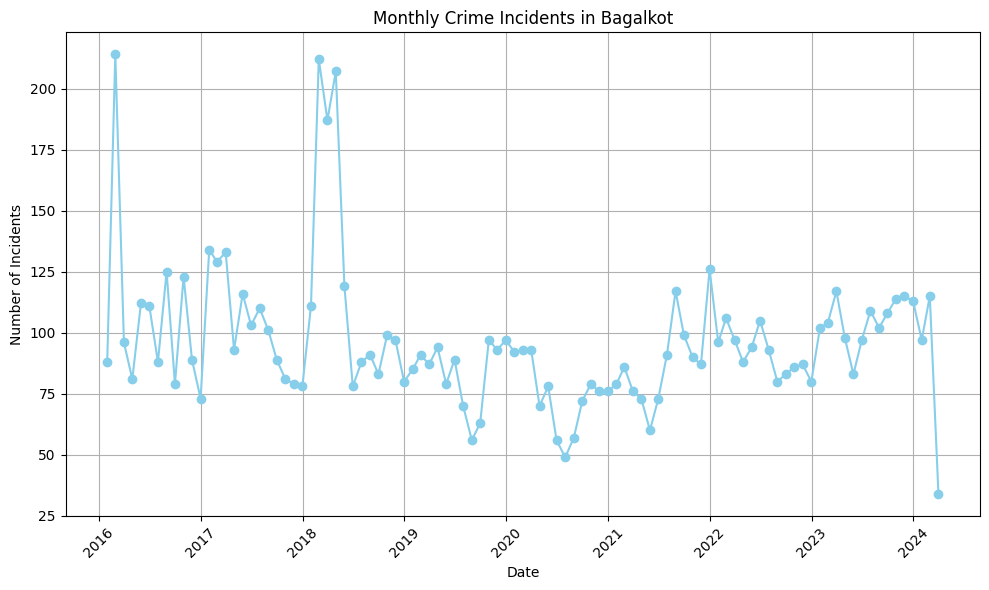

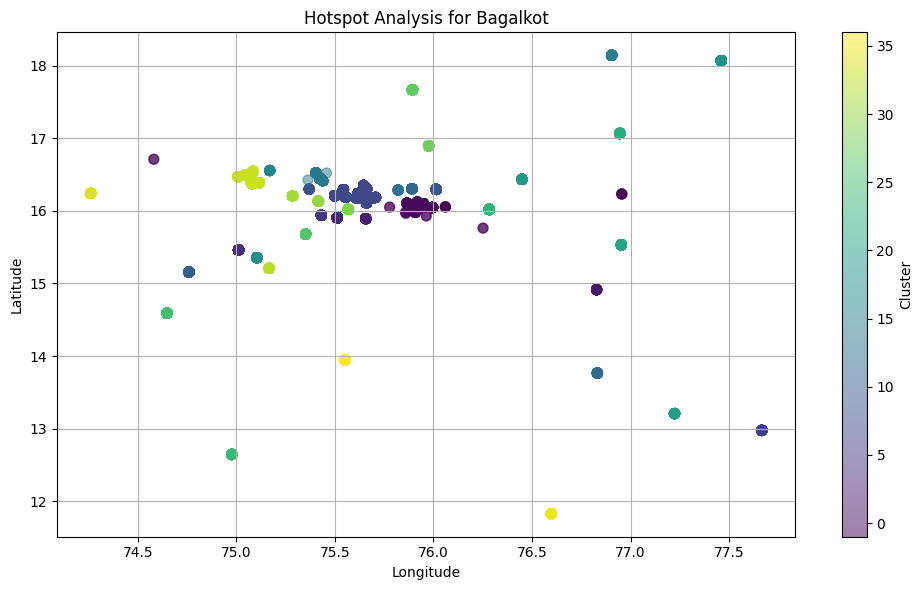


Suggestions for Improving the Situation in Bagalkot
- Increase police patrols and presence in high-crime areas.
- Implement community policing initiatives to build trust and collaboration with residents.
- Enhance public safety measures such as improved street lighting and surveillance cameras.
- Provide support services for at-risk populations, including youth outreach programs and substance abuse treatment.
- Implement crime prevention through environmental design (CPTED) principles to create safer urban environments.


In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
# Load the data
data = pd.read_csv('FIR_Details_Data.csv')

# Ask user to input district name
district_name = input("Enter the district name: ")

# Filter data for the selected district
district_data = data[data['District_Name'] == district_name]

if district_data.empty:
    print("District not found.")
else:
    # 1. Types of Crimes
    crime_type_counts = district_data['CrimeGroup_Name'].value_counts()
    print("\nTypes of Crimes in", district_name)
    print(crime_type_counts)

    # 2. Trends Over Time (Monthly)
    district_data['Date'] = pd.to_datetime(district_data[['Year', 'Month']].assign(day=1))
    monthly_crime_counts = district_data.groupby(pd.Grouper(key='Date', freq='M')).size()
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_crime_counts.index, monthly_crime_counts.values, marker='o', color='skyblue')
    plt.title('Monthly Crime Incidents in {}'.format(district_name))
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

 # Extract latitude and longitude coordinates
    coordinates = district_data[['Latitude', 'Longitude']]

    # Standardize the coordinates
    scaler = StandardScaler()
    coordinates_scaled = scaler.fit_transform(coordinates)

    # Perform DBSCAN clustering
    eps = 0.1  # Adjust epsilon based on the density of incidents
    min_samples = 10  # Adjust minimum number of samples based on the expected density
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(coordinates_scaled)

    # Plot clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(district_data['Longitude'], district_data['Latitude'], c=clusters, cmap='viridis', s=50, alpha=0.5)
    plt.title('Hotspot Analysis for {}'.format(district_name))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Preventive Measures (Suggested)
    print("\nSuggestions for Improving the Situation in", district_name)
    print("- Increase police patrols and presence in high-crime areas.")
    print("- Implement community policing initiatives to build trust and collaboration with residents.")
    print("- Enhance public safety measures such as improved street lighting and surveillance cameras.")
    print("- Provide support services for at-risk populations, including youth outreach programs and substance abuse treatment.")
    print("- Implement crime prevention through environmental design (CPTED) principles to create safer urban environments.")
